In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.ticker import FormatStrFormatter

import cell_order_log_analysis

import sys
sys.path.append('../radio_api')
import mcs_mapper
import constants

In [2]:
FIG_SIZE = (5,4.5)
FONT_SIZE = 16
LINE_STYLE = (0,(4,4))
LINE_WIDTH = 2.5
SAVE_FIG = False

RESERVATION = 'RES130665'
reservation_data_dir = '../data/' + RESERVATION + '/'
cell_order_log_filename = reservation_data_dir + 'cell-order-increasingRbg-lat.log'
cell_order_ue_log_filename = reservation_data_dir + 'cell-order-ue2-increasingRbg-lat.log'

if (SAVE_FIG):
    reservation_out_dir = '../outputs/' + RESERVATION + '/'
    if (not os.path.exists(reservation_out_dir)):
        os.mkdir(reservation_out_dir)

SLA_PERIOD = 30 # seconds over which the SLAs are negotiated
OUTLIER_PERCENTILE = 5 # Percentile to clip-off from both ends for each SLA period

In [3]:
bs_data, budgets, ts_start = cell_order_log_analysis.read_cell_order_log(cell_order_log_filename)

cur_data, slice_id, _ = cell_order_log_analysis.read_cell_order_ue_log(cell_order_ue_log_filename, ts_start)
cur_data['supply_times'] -= ts_start
ue_data = {slice_id: cur_data}

active_slice = list(ue_data.keys())[0]
assert active_slice in bs_data.keys()

Data for 478.0160000324249 seconds has been extracted
UE Data for 474.47900009155273 seconds has been extracted


In [4]:
for user_id, supply_times in budgets['supply_times'].items():
    port_offset = int(user_id[0].split('.')[-1])
    sid = port_offset % constants.SLICE_NUM
    
    bs_data[sid]['filtered_ts_sec'] = np.array([])
    bs_data[sid]['filtered_lat_msec'] = np.array([])
    for supply_time in supply_times:
        supply_time -= ts_start
        ts_filter = np.logical_and(bs_data[sid]['raw_ts_sec'] >= supply_time,
                                   bs_data[sid]['raw_ts_sec'] < supply_time + SLA_PERIOD + 1)
        if (not ts_filter.any()):
            continue
        sla_ts_sec = bs_data[sid]['raw_ts_sec'][ts_filter]
        sla_lat_msec = bs_data[sid]['raw_lat_msec'][ts_filter]

        outlier_filter = np.logical_and(sla_lat_msec <= np.percentile(sla_lat_msec, 100 - OUTLIER_PERCENTILE),
                                        sla_lat_msec >= np.percentile(sla_lat_msec, OUTLIER_PERCENTILE))
        if (outlier_filter.any()):
            bs_data[sid]['filtered_ts_sec'] = \
                np.concatenate((bs_data[sid]['filtered_ts_sec'], sla_ts_sec[outlier_filter]))
            bs_data[sid]['filtered_lat_msec'] = \
                np.concatenate((bs_data[sid]['filtered_lat_msec'], sla_lat_msec[outlier_filter]))
        else:
            bs_data[sid]['filtered_ts_sec'] = \
                np.concatenate((bs_data[sid]['filtered_ts_sec'], np.median(sla_ts_sec)))
            bs_data[sid]['filtered_lat_msec'] = \
                np.concatenate((bs_data[sid]['filtered_lat_msec'], np.median(sla_lat_msec)))

In [5]:
ue_data[active_slice]['filtered_ts_sec'] = np.array([])
ue_data[active_slice]['filtered_rtt_msec'] = np.array([])
ue_data[active_slice]['raw_n_rbgs'] = np.array([])
cur_n_rbg = 1
for supply_time in ue_data[active_slice]['supply_times']:
    ts_filter = np.logical_and(ue_data[active_slice]['raw_ts_sec'] >= supply_time,
                               ue_data[active_slice]['raw_ts_sec'] < supply_time + SLA_PERIOD + 1)
    if (not ts_filter.any()):
        continue
    sla_ts_sec = ue_data[active_slice]['raw_ts_sec'][ts_filter]
    sla_rtt_msec = ue_data[active_slice]['raw_rtt_msec'][ts_filter]

    outlier_filter = np.logical_and(sla_rtt_msec <= np.percentile(sla_rtt_msec, 100 - OUTLIER_PERCENTILE),
                                    sla_rtt_msec >= np.percentile(sla_rtt_msec, OUTLIER_PERCENTILE))
    if (outlier_filter.any()):
        ue_data[active_slice]['filtered_ts_sec'] = \
            np.concatenate((ue_data[active_slice]['filtered_ts_sec'], sla_ts_sec[outlier_filter]))
        ue_data[active_slice]['filtered_rtt_msec'] = \
            np.concatenate((ue_data[active_slice]['filtered_rtt_msec'], sla_rtt_msec[outlier_filter]))
    else:
        ue_data[active_slice]['filtered_ts_sec'] = \
            np.concatenate((ue_data[active_slice]['filtered_ts_sec'], np.median(sla_ts_sec)))
        ue_data[active_slice]['filtered_rtt_msec'] = \
            np.concatenate((ue_data[active_slice]['filtered_rtt_msec'], np.median(sla_rtt_msec)))
            
    ue_data[active_slice]['raw_n_rbgs'] = \
        np.concatenate((ue_data[active_slice]['raw_n_rbgs'], np.full(sla_ts_sec.shape, cur_n_rbg)))

    cur_n_rbg += 1

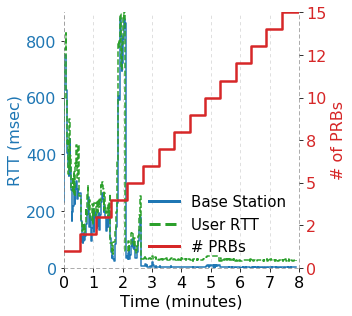

In [6]:
fig, ax1 = plt.subplots(figsize=FIG_SIZE)

color = 'C0'
ax1.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax1.set_ylabel('RTT (msec)', color=color, fontsize=FONT_SIZE)
ln1 = plt.step(bs_data[active_slice]['filtered_ts_sec'] / 60, 
               bs_data[active_slice]['filtered_lat_msec'], 
               where='pre', color=color, linestyle='-', label='Base Station')
ln2 = plt.step(ue_data[active_slice]['filtered_ts_sec'] / 60, 
               ue_data[active_slice]['filtered_rtt_msec'], 
               where='pre', color='C2', linestyle='--', label='User RTT')
ax1.tick_params(axis='y', labelcolor=color, labelsize=FONT_SIZE)
ax1.tick_params(axis='x', labelsize=FONT_SIZE)
ax1.set_ylim((0, 900))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'C3'
ax2.set_ylabel('# of PRBs', color=color, fontsize=FONT_SIZE)
ln3 = plt.step(bs_data[active_slice]['raw_ts_sec'] / 60, 
               bs_data[active_slice]['raw_n_rbgs'], 
               where='pre', color=color, label='# PRBs', linewidth=LINE_WIDTH)
ax2.tick_params(axis='y', labelcolor=color, labelsize=FONT_SIZE)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax2.set_ylim((0, 15))

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
leg= ax2.legend(lns, labs, loc='best', frameon=False, 
                fontsize=FONT_SIZE-1, ncol=1)
for line in leg.get_lines():
    line.set_linewidth(3)

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
ax2.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)

plt.xlim([0,8])
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end+1))

ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'lat_and_prbs.pdf')

plt.show()

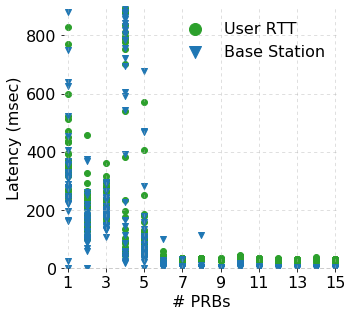

In [7]:
fig, ax1 = plt.subplots(figsize=FIG_SIZE)

ax1.set_xlabel('# PRBs', fontsize=FONT_SIZE)
ax1.set_ylabel('Latency (msec)', fontsize=FONT_SIZE)

plt.scatter(ue_data[active_slice]['raw_n_rbgs'], 
            ue_data[active_slice]['raw_rtt_msec'], 
            color='C2', label='User RTT', marker='o')
plt.scatter(bs_data[active_slice]['raw_n_rbgs'], 
            bs_data[active_slice]['raw_lat_msec'], 
            color='C0', label='Base Station', marker='v')

ax1.tick_params(axis='y', labelsize=FONT_SIZE)
ax1.tick_params(axis='x', labelsize=FONT_SIZE)
ax1.set_ylim((0, 900))
ax1.set_xlim([0.8,15.2])
ax1.xaxis.set_ticks(np.arange(1, 16, 2))

ax1.legend(loc='upper right', frameon=False, fontsize=FONT_SIZE, markerscale=2)

ax1.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'lat_vs_prbs.pdf')

plt.show()